## 回帰: 住宅価格予測

#### データのロード

In [88]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [89]:
train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

((404, 13), (404,), (102, 13), (102,))

In [90]:
train_targets[0]

15.2

#### 特徴量データの正規化

In [91]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#テストデータもトレーニングデータの値を使って行う
test_data -= mean
test_data /= std

#### モデルの定義

In [92]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### k分割交差検証

In [94]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k ## //は切り捨て除算
num_epochs = 500
all_mae_histories = [ ]
for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[ : i * num_val_samples], train_data[(i+1) * num_val_samples : ]], axis=0)
    partial_train_targets = np.concatenate([train_targets[ : i * num_val_samples], train_targets[(i+1) * num_val_samples : ]], axis=0)

    model = build_model()
        
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Text(0,0.5,'Validation MAE')

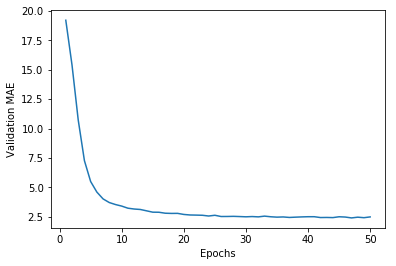

In [95]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

#### 移動平均をとってみやすく

Text(0,0.5,'Validation MAE')

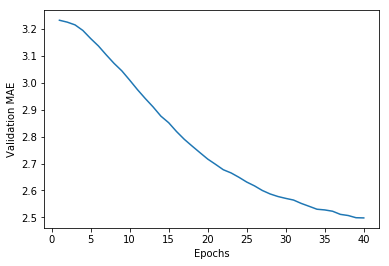

In [96]:
def smooth_curve(points, factor=0.9):
    smoothed_points = [ ]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.figure()
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

#### 最終的なモデルの訓練

In [97]:
#80 epochでとめるのがよさそう。

model = build_model()
history = model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
results = model.evaluate(test_data, test_targets)
results

102/102 [==============================] - 0s 2ms/step


[13.675389084161496, 2.4878306669347428]

In [3]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }</style>")) 